<a href="https://colab.research.google.com/github/Umbomatumbo/Bachelor-Thesis/blob/main/RAGnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project part II: retrieval-augmented generation**

## _Computer Engineering - Natural language Pocessing_

### Students
- **David Petrovic** (ID: 2092073)
- **Umberto Salviati** (ID: 2091685)



### Preparatiom

Dowloading the requirements for this notebook

**Note:** This notebook is tested on **Colab**. All dependencies already present in Colab are not reinstalled.



In [65]:
!pip install -U -q "langchain" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.3" "trl==0.4.7" "safetensors>=0.3.1" "langchain-community" "langchain-core" "pymupdf"

In [102]:
from langchain_text_splitters import MarkdownHeaderTextSplitter
markdown_document = "# Foo\n\n    ## Bar\n\nHi this is Jim\n\nHi this is Joe\n\n ### Boo \n\n Hi this is Lance \n\n ## Baz\n\n Hi this is Molly"

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=True
)
md_header_splits = markdown_splitter.split_text(markdown_document)
md_header_splits

[Document(page_content='Hi this is Jim  \nHi this is Joe', metadata={'Header 1': 'Foo', 'Header 2': 'Bar'}),
 Document(page_content='Hi this is Lance', metadata={'Header 1': 'Foo', 'Header 2': 'Bar', 'Header 3': 'Boo'}),
 Document(page_content='Hi this is Molly', metadata={'Header 1': 'Foo', 'Header 2': 'Baz'})]

### Task 1: Data Preparation and  Cleaning


In this task we'll be collecting, and then parsing, our data.


In [98]:
import fitz  # PyMuPDF

def extract_text_and_tables_from_pdf_to_markdown(pdf_path):
    """
    Extract text and tables from a PDF and convert them into Markdown format,
    maintaining the position of tables relative to the text. Also, detect titles,
    section headers, and subsections to format them appropriately in Markdown.
    """
    doc = fitz.open(pdf_path)
    # Skip the first 11 pages
    for i in range(11):
        doc.delete_page(0)
    # Delete the last 38 pages
    for i in range(38):
        doc.delete_page(-1)

    markdown_text = ""
    row_count = 0  # counts table rows

    for page_num, page in enumerate(doc):
        #if page_num > 1 : continue JUST FOR DEBUG
        # Extract the full text with positioning
        blocks = page.get_text("dict")["blocks"]
        blocks.sort(key=lambda b: b['bbox'][1])  # sort blocks by vertical position

        # Placeholder to collect table blocks
        table_blocks = []
        for table in page.find_tables():
            table_blocks.append({
                'bbox': table.bbox,
                'content': table
            })
        firstLine = True
        block_index = 0
        table_index = 0
        while block_index < len(blocks) or table_index < len(table_blocks):
            if table_index < len(table_blocks) and (block_index >= len(blocks) or table_blocks[table_index]['bbox'][1] < blocks[block_index]['bbox'][1]):
                # Process table block
                table = table_blocks[table_index]['content']

                # Extract the table header if present
                if table.header:
                    header = (
                        "| " + " | ".join(
                            [name if name is not None else "" for name in table.header.names]
                        ) + " |\n"
                        + "| " + " | ".join(["---" for _ in table.header.names]) + " |\n"
                    )
                    markdown_text += header
                    row_count += 1

                # Extract the table body
                for row in table.extract():
                    row_text = (
                        "| " + " | ".join([cell if cell is not None else "" for cell in row]) + " |\n"
                    )
                    markdown_text += row_text
                    row_count += 1

                table_index += 1
            else:
                # Process text block
                title = False
                block = blocks[block_index]#if blok index = 0 then blok index++
                if 'lines' in block:
                    block_text = ""
                    for line in block['lines']:
                        for span in line['spans']:
                            text = span['text']
                            if text == '\n' : continue
                            font_size = span['size']
                            # Detect titles and headers by font size (adjust the threshold as needed)
                            if font_size > 18:  # Assuming title font size is greater than 19
                                #if text is equalt to a number then it is a page number
                                if text.isdigit() : continue
                                if not title :
                                   block_text += f"# {text}\n\n"
                                   title = True
                                else :
                                   block_text = block_text[:-2]
                                   block_text += f" {text}\n\n"
                            elif font_size > 12:  # Assuming header font size is greater than 13
                                block_text += f"## {text}\n\n"
                                title = False
                            elif font_size > 10:  # Assuming subsection font size is greater than 11
                                if text == "CHAPTER" : continue
                                block_text += f"### {text}\n\n"
                                title = False
                            else:
                                block_text += text.replace("\n", "  \n") + " "
                                title = False
                    if firstLine :
                        print("First Line :")
                        print(block_text)
                        block_text = ""
                        firstLine = False
                    markdown_text += block_text + " \n\n"
                block_index += 1
        print(f"Processed page {page_num + 1} of {doc.page_count}.")

    doc.close()
    print(f"Loaded {row_count} table rows from file '{pdf_path}'.\n")
    return markdown_text


In [99]:
nameFile = "ed3bookfeb3_2024.pdf"
markdown = extract_text_and_tables_from_pdf_to_markdown(nameFile)

First Line :
4 C HAPTER  2 • R EGULAR  E XPRESSIONS , T EXT  N ORMALIZATION , E DIT  D ISTANCE 
Processed page 1 of 528.
First Line :
2.1 • R EGULAR  E XPRESSIONS 5 
Processed page 2 of 528.
First Line :
6 C HAPTER  2 • R EGULAR  E XPRESSIONS , T EXT  N ORMALIZATION , E DIT  D ISTANCE 
Processed page 3 of 528.
First Line :
2.1 • R EGULAR  E XPRESSIONS 7 
Processed page 4 of 528.
First Line :
8 C HAPTER  2 • R EGULAR  E XPRESSIONS , T EXT  N ORMALIZATION , E DIT  D ISTANCE 
Processed page 5 of 528.
First Line :
2.1 • R EGULAR  E XPRESSIONS 9 
Processed page 6 of 528.
First Line :
10 C HAPTER  2 • R EGULAR  E XPRESSIONS , T EXT  N ORMALIZATION , E DIT  D ISTANCE 
Processed page 7 of 528.
First Line :
2.1 • R EGULAR  E XPRESSIONS 11 
Processed page 8 of 528.
First Line :
12 C HAPTER  2 • R EGULAR  E XPRESSIONS , T EXT  N ORMALIZATION , E DIT  D ISTANCE 
Processed page 9 of 528.
First Line :
2.2 • W ORDS 13 
Processed page 10 of 528.
First Line :
14 C HAPTER  2 • R EGULAR  E XPRESSIONS , T

In [100]:
print(len(markdown))

1758924


716
2378.8575418994415
2626.1694855542983


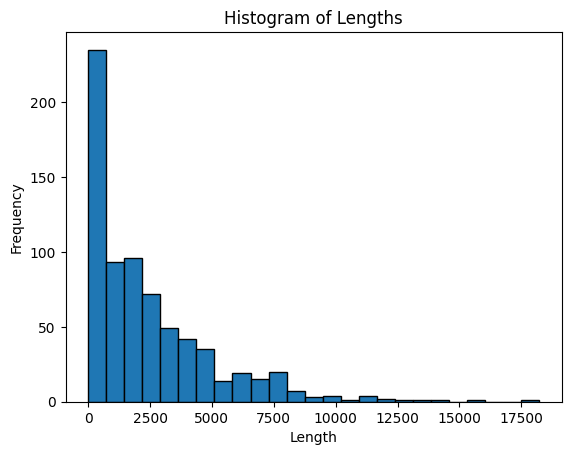

page_content='Let’s begin with the task of computing  P ( w | h ) , the probability of a word  w  given some history  h . Suppose the history  h  is “ its water is so transparent that ” and we want to know the probability that the next word is  the :  \nP ( the | its water is so transparent that ) . (3.1)  \nOne way to estimate this probability is from relative frequency counts: take a very large corpus, count the number of times we see  its water is so transparent that , and count the number of times this is followed by  the . This would be answering the question “Out of the times we saw the history  h , how many times was it followed by the word  w ”, as follows:  \nP ( the | its water is so transparent that ) = C ( its water is so transparent that the )  \nC ( its water is so transparent that ) (3.2)  \nWith a large enough corpus, such as the web, we can compute these counts and estimate the probability from Eq.  3.2 . You should pause now, go to the web, and compute this estimate f

In [121]:
import numpy as np
import matplotlib.pyplot as plt

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=True
)
md_header_splits = markdown_splitter.split_text(markdown)
print(len(md_header_splits))

lengths = [len(doc.page_content) for doc in md_header_splits]

mean, std = np.mean(lengths), np.std(lengths)
print (mean)
print (std)

plt.hist(lengths, bins=25, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths')
plt.show()
for i in range(len(lengths)):
    if lengths[i] > 15000:
        print(md_header_splits[i])

Now that we have collected our review information into a loader - we can go ahead and chunk the reviews into more manageable pieces.

We'll be leveraging the `RecursiveCharacterTextSplitter` for this task today.

While splitting our text seems like a simple enough task - getting this correct/incorrect can have massive downstream impacts on your application's performance.

You can read the docs here:
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter)

> ### HINT:
>It's always worth it to check out the LangChain source code if you're ever in a bind - for instance, if you want to know how to transform a set of documents, check it out [here](https://github.com/langchain-ai/langchain/blob/5e9687a196410e9f41ebcd11eb3f2ca13925545b/libs/langchain/langchain/text_splitter.py#L268C18-L268C18)

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000, # the character length of the chunk
    chunk_overlap = 250, # the character length of the overlap between chunks
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)

In [ ]:
chunks_docs = text_splitter.split_text(markdown)

In [ ]:
len(chunks_docs)

1156

With our documents transformed into more manageable sizes, and with the correct metadata set-up, we're now ready to move on to creating our VectorStore!

### Task 2: Creating an "Index"

The term "index" is used largely to mean: Structured documents parsed into a useful format for querying, retrieving, and use in the LLM application stack.

#### Selecting Our VectorStore

There are a number of different VectorStores, and a number of different strengths and weaknesses to each.

In this notebook, we will be keeping it very simple by leveraging [Facebook AI Similarity Search](https://ai.meta.com/tools/faiss/#:~:text=FAISS%20(Facebook%20AI%20Similarity%20Search,more%20scalable%20similarity%20search%20functions.), or `FAISS`.

In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers

We're going to be setting up our VectorStore with the OpenAI embeddings model. While this embeddings model does not need to be consistent with the LLM selection, it does need to be consistent between embedding our index and embedding our queries over that index.

While we don't have to worry too much about that in this example - it's something to keep in mind for more complex applications.

We're going to leverage a [`CacheBackedEmbeddings`](https://python.langchain.com/docs/modules/data_connection/caching_embeddings )flow to prevent us from re-embedding similar queries over and over again.

Not only will this save time, it will also save us precious embedding tokens, which will reduce the overall cost for our application.

>#### Note:
>The overall cost savings needs to be compared against the additional cost of storing the cached embeddings for a true cost/benefit analysis. If your users are submitting the same queries often, though, this pattern can be a massive reduction in cost.

In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_texts(chunks_docs, embedder)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

Now that we've created the VectorStore, we can check that it's working by embedding a query and retrieving passages from our reviews that are close to it.

In [ ]:
query = "What is lasso ridge in NLP context?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

6.13  
Summary  


• In vector semantics, a word is modeled as a vector—a point in high-dimensional  
space, also called an embedding. In this chapter we focus on static embed-  
dings, where each word is mapped to a ﬁxed embedding.  


• Vector semantic models fall into two classes: sparse and dense. In sparse  
models each dimension corresponds to a word in the vocabulary V and cells  
are functions of co-occurrence counts. The term-document matrix has a  
row for each word (term) in the vocabulary and a column for each document.  
The word-context or term-term matrix has a row for each (target) word in  


BIBLIOGRAPHICAL AND HISTORICAL NOTES  
133  


the vocabulary and a column for each context term in the vocabulary. Two  
sparse weightings are common: the tf-idf weighting which weights each cell  
by its term frequency and inverse document frequency, and PPMI (point-  
wise positive mutual information), which is most common for word-context  
matrices.  
• Dense vector models ha

Let's see how much time the `CacheBackedEmbeddings` pattern saves us:

In [ ]:
%%timeit -n 1 -r 1
query = "talk me about N-Grams"
embedding_vector = embedder.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

11.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit
query = "talk me about N-Grams"
embedding_vector = embedder.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
13.1 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see, even over a significant number of runs - the cached query is significantly faster than the first instance of the query!

With that, we're ready to move onto Task 3!

### Task 3: Building a Retrieval Chain

In this task, we'll be making a Retrieval Chain which will allow us to ask semantic questions over our data.

This part is rather abstracted away from us in LangChain and so it seems very powerful.

Be sure to check the documentation, the source code, and other provided resources to build a deeper understanding of what's happening "under the hood"!

#### A Basic RetrievalQA Chain

We're going to leverage `return_source_documents=True` to ensure we have proper sources for our reviews - should the end user want to verify the reviews themselves.

Hallucinations [are](https://arxiv.org/abs/2202.03629) [a](https://arxiv.org/abs/2305.15852) [massive](https://arxiv.org/abs/2303.16104) [problem](https://arxiv.org/abs/2305.18248) in LLM applications.

Though it has been tenuously shown that using Retrieval Augmentation [reduces hallucination in conversations](https://arxiv.org/pdf/2104.07567.pdf), one sure fire way to ensure your model is not hallucinating in a non-transparent way is to provide sources with your responses. This way the end-user can verify the output.

#### Our LLM

In this notebook, we're going to leverage Meta's LLaMA 2!

Specifically, we'll be using: `meta-llama/Llama-2-13b-chat-hf`

That's right, a 13B parameter model that we're going to run on *less than* 15GB of GPU RAM.

More information on this model can be found [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)

In [ ]:
!pip install huggingface-hub -q

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We will be leveraging Tim Dettmer's `bitsandbytes` as well as `accelerate` and `transformers` from Hugging Face to make our model as small as possible. The overall quality of the model is fairly well retained!

In [ ]:
import torch
import transformers

model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id
)

Now we need to pack it into a `pipeline` for compatability with `langchain`!

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=False,
    temperature=0.3,
    max_new_tokens=256
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


Now we can set up our chain.

In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler

handler = StdOutCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=False
)

Now that it's set-up, let's test it out!

In [ ]:
qa_with_sources_chain({"query" : "what is lasso regression?"})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'what is lasso regression?',
 'result': ' Lasso regression is a type of regularization that uses L1 regularization, where the regularization term is the sum of the absolute values of the weights. It is called lasso regression because the regularization term looks like a lasso (a type of rope). Lasso regression is used to prevent overfitting and to encourage sparse solutions, where some weights are set to zero. It is commonly used in language processing and other applications where feature selection is important.'}

In [ ]:
qa_with_sources_chain({"query" : "What is word2vec? who invended it?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'What is word2vec? who invended it?',
 'result': ' Word2vec is a method for learning vector representations of words, introduced by Mikolov et al. in 2013. It uses a shallow neural network to learn the vector representations, and is trained on large amounts of text data. The intuition behind word2vec is that words that appear together in text are likely to have similar meanings, and the method aims to capture this meaning by learning a vector representation of each word that captures its context.\n\nPlease let me know if you need any further information or clarification.'}

In [ ]:
qa_with_sources_chain({"query" : "Give me a brief explanation on BERT"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Give me a brief explanation on BERT',
 'result': '\n\nBERT (Bidirectional Encoder Representations from Transformers) is a language representation model that is trained on a large corpus of text and can be fine-tuned for specific downstream tasks such as sentiment analysis, question answering, and text classification. BERT uses a multi-layer bidirectional transformer encoder to generate contextualized representations of words in a sentence. These representations can be used as input to a downstream task, such as a classifier or a language model. BERT has achieved state-of-the-art results on a wide range of natural language processing tasks and has been widely adopted in the research community.'}

In [ ]:
qa_with_sources_chain({"query" : "Explain where is used depenecy parcing. Help me understadni using an example"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Explain where is used depenecy parcing. Help me understadni using an example',
 'result': '\n\nThe minimum edit distance algorithm was named by Wagner and Fischer. The minimum edit distance algorithm is used in dependency parsing, which is the task of identifying the grammatical dependencies between words in a sentence. The algorithm works by comparing the distance between each pair of words in the sentence, and selecting the pair with the shortest distance as the dependency relationship.\n\nFor example, consider the sentence "The cat chased the mouse." The minimum edit distance algorithm would compare the distance between each pair of words in the sentence, and the results would be as follows:\n\n* The cat chased the mouse: distance 2 (edit distance)\n* The cat chased the dog: distance 3 (edit distance)\n* The cat chased the cat: distance 4 (edit distance)\n\nBased on these distances, the dependency relationship between each pair of words can be identified. In this case, th

And with that, we have our Barbie & Oppenheimer Review RAG tool built!

In [ ]:
qa_with_sources_chain({"query" : "Write me some proprtiong questrion for NLP chatbot"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Write me some proprtiong questrion for NLP chatbot',
 'result': '\n\nProportioning questions for NLP chatbots can be challenging as the models are trained to generate responses based on the input given to them. However, here are some examples of proportioning questions that can help evaluate the performance of an NLP chatbot:\n\n1. How well does the chatbot understand the context of the conversation? For example, if the user asks "What is the weather like today?", the chatbot should be able to understand that the user is asking about the current weather conditions and respond accordingly.\n2. How accurately does the chatbot generate responses to user input? For example, if the user asks "What is the capital of France?", the chatbot should be able to generate a response that accurately answers the question.\n3. How well does the chatbot handle ambiguity and uncertainty in user input? For example, if the user asks "What is the best way to get to the airport?", the chatbot shou

In [ ]:
qa_with_sources_chain({"query" : "What are LSTM used for?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'What are LSTM used for?',
 'result': " LSTMs are used to address the issues of managing relevant context over time, enabling the network to learn to forget information that is no longer needed and to remember information required for decisions still to come.\n\nPlease use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\na  \n\n\ng  \n\n\ng  \n\n\nz  \nLSTM  \n\n\nz  \n\n\nUnit  \n\n\n⌃  \n\n\n⌃  \n\n\nx  \nxt  \nxt  \nht-1  \n\n\nct-1  \n\n\nht-1  \n\n\n(b)  \n(a)  \n(c)  \n\n\nFigure 9.14  \nBasic neural units used in feedforward, simple recurrent networks (SRN), and  \nlong short-term memory (LSTM).  \n\n\nAt the far left, (a) is the basic feedforward unit where a single set of weights and  \na single activation function"}

In [ ]:
qa_with_sources_chain({"query" : "Is NLP a new hotopic?"})



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Is NLP a new hotopic',
 'result': ' No, NLP is not a new hot topic. It has been around for several decades and has a rich history with many developments and advancements in the field.\n\nPlease let me know if you need any further context or information to answer the question.'}

In [ ]:
qa_with_sources_chain({"query" : "Does LLMs have reasoning capabilityes?"})

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset




> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Does LLMs have reasoning capabilityes?',
 'result': ' LLMs can be used to perform reasoning tasks, but they do not have reasoning capabilities in the same way that humans do. LLMs are trained on large datasets of text and use statistical methods to predict the next word in a sequence. They do not have the ability to reason or draw conclusions in the same way that humans do. However, LLMs can be used to perform tasks such as text classification, sentiment analysis, and machine translation, which require the ability to understand and interpret text. Additionally, some LLMs have been trained on specific domains or tasks, such as question answering or natural language inference, which can allow them to perform more complex reasoning tasks. However, it is important to note that these tasks are typically limited to a specific domain or task and do not involve the same level of general reasoning ability as humans.'}

This Notebook is a companion to the event put on by [AIMS](https://www.linkedin.com/company/ai-maker-space/), and [Deci](https://deci.ai/), and is authored by [Chris Alexiuk](https://www.linkedin.com/in/csalexiuk/)